<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1>

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||

<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

## <b> Librerías necesarias: </b>


In [ ]:
# import the necessary packages
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import argparse
import cv2
import glob
from pandas import DataFrame
import sklearn
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy import stats
import operator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## <b> Montaje de unidad Google Drive en el entorno de ejecución: </b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

Mounted at /content/drive
/content/drive/MyDrive/Implementación Proyecto Grado Maestría


## <b> Verificación presencia de GPU: </b>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataPath = "all-mias"

mob_dn_folder = '/mob_dn_seg_U_Net_bin'

dataPath01 = dataPath + mob_dn_folder

if os.path.isdir(dataPath01) is False:
  os.mkdir(dataPath01)

textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


## <b> Reemplazo (llenado) de valores vacíos o nulos: </b>

In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
#mias_df.head()

## <b> Cambio de números decimales a enteros: </b>

In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
#mias_df.head()
print(mias_df)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        B  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[330 rows x 7 columns]


Hay 330 filas, porque hay 330 etiquetas en total. Pero hay 322 imágenes porque algunas imágenes tienen más de una anomalía sea benigna o maligna.

Las que aparecen más de una vez son:

mdb005 2 veces

mdb132 2 veces

mdb144 2 veces (B y M)

mdb223 2 veces

mdb226 3 veces

mdb239 2 veces

mdb249 2 veces

Es decir, hay 8 repetidas en la lista.

In [ ]:
#Drop a las anormales que no están marcadas por experto:
mias_df_new = mias_df.drop(mias_df[(mias_df['SEVERITY'] != 'N') & (mias_df['RADIUS'] == 0)].index)
print(mias_df_new)

print("\nLabeled abnormalities (more than one in some images) and labeled as normal: ", mias_df_new.shape)

#Split by class:
abnormalClass = mias_df_new[mias_df_new.SEVERITY!='N']
print("Labeled as abnormal: ", abnormalClass.shape)
normalClass = mias_df_new[mias_df_new.SEVERITY=='N']
print("Labeled as normal: ", normalClass.shape)

#Unique REFNUM:
mias_df_uniques = mias_df_new.drop_duplicates(subset = ["REFNUM"]) #REFNUM únicos porque se repiten para número de imgs no de anormalidades presentes
abnormal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY!='N']
normal_uniques = mias_df_uniques[mias_df_uniques.SEVERITY=='N']
print("\nNumber of images: ", mias_df_uniques.shape)
print("Number of abnormal images: ", abnormal_uniques.shape)
print("Number of normal images: ", normal_uniques.shape)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
2    mdb003  D  NORM        N    0    0       0
3    mdb004  D  NORM        N    0    0       0
4    mdb005  F  CIRC        B  477  133      30
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[326 rows x 7 columns]

Labeled abnormalities (more than one in some images) and labeled as normal:  (326, 7)
Labeled as abnormal:  (117, 7)
Labeled as normal:  (209, 7)

Number of images:  (318, 7)
Number of abnormal images:  (109, 7)
Number of normal images:  (209, 7)


In [ ]:
orig_path = dataPath+'/seg_breast_eq_U_Net_msks_bin/'
#comp_name = '_processed.png'
comp_name = '_output.png'

abnormal_fileNames = abnormalClass.REFNUM
normal_fileNames = normalClass.REFNUM

abnormal_path = dataPath01+'/abnormal/'
normal_path = dataPath01+'/normal/'


#Descomentar si se van a generar las carpetas nuevamente desde cero:

if os.path.isdir(abnormal_path) is False:
    os.makedirs(abnormal_path)
    os.makedirs(normal_path)

    for image_name in abnormal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', benign_processed_path)
        shutil.copy(orig_path + image_name + comp_name, abnormal_path)

    for image_name in normal_fileNames:
        #shutil.copy(dataPath+'/all-miasPythonProcessed/'+image_name+'_processed.png', normal_processed_path)
        shutil.copy(orig_path + image_name + comp_name, normal_path)


In [ ]:
#Number of images: 318
#Number of abnormal images: 109
#Number of normal images: 209

#Train: aprox. 70%
#Valid: aprox. 15%
#Test : aprox. 15% :

if os.path.isdir(dataPath01+'/train/abnormal') is False:
    os.makedirs(dataPath01+'/train/abnormal')
    os.makedirs(dataPath01+'/train/normal')
    os.makedirs(dataPath01+'/valid/abnormal')
    os.makedirs(dataPath01+'/valid/normal')
    os.makedirs(dataPath01+'/test/abnormal')
    os.makedirs(dataPath01+'/test/normal')

    #train:
    for c in random.sample(glob.glob(abnormal_path+'/*.png'), 77):
        shutil.move(c, dataPath01+'/train/abnormal')
    for c in random.sample(glob.glob(normal_path+'/*.png'), 147):
        shutil.move(c, dataPath01+'/train/normal')
    #valid:
    for c in random.sample(glob.glob(abnormal_path+'/*.png'), 16):
        shutil.move(c, dataPath01+'/valid/abnormal')
    for c in random.sample(glob.glob(normal_path+'/*.png'), 31):
        shutil.move(c, dataPath01+'/valid/normal')
    #test:
    for c in random.sample(glob.glob(abnormal_path+'/*.png'), 16):
        shutil.move(c, dataPath01+'/test/abnormal')
    for c in random.sample(glob.glob(normal_path+'/*.png'), 31):
        shutil.move(c, dataPath01+'/test/normal')

    shutil.rmtree(abnormal_path)
    shutil.rmtree(normal_path)

## <b> Data Augmentation </b>

In [ ]:
def augmentImages(images_paths, dir, imgs_per_image, pixel_fill):
  #images_paths = glob.glob(images_path+'/*.png')

  #Trataré de meter las imágenes a un arreglo para que sean leídas más rápido cuando haga el augmentation:
  imgs_arr=[]
  imgs_names_arr=[]
  for myFile in images_paths:
    image = cv2.imread(myFile)
    imgs_arr.append(image)
    basename = os.path.basename(myFile)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto
    imgs_names_arr.append(name)

  for myImage, myName in zip(imgs_arr, imgs_names_arr):
    image = np.expand_dims(myImage,0)
    #min_pixel = np.min(image)
    #min_pixel = 239 #np.max(image)
    #gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=pixel_fill, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)# brightness_range=[0.6,1.3])

    gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
                              cval=pixel_fill, shear_range=0.15, horizontal_flip=True)# brightness_range=[0.6,1.3])
    #gen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15, fill_mode='constant',
    #                          cval=min_pixel, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)

    #Save augmented images
    aug_iter = gen.flow(image, save_to_dir=dir, save_prefix='aug_'+myName, save_format='png', seed=1)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(imgs_per_image)]

In [ ]:
image = cv2.imread(orig_path + 'mdb001' + comp_name)
pix_fill = image[0][0][0]

#Anormales para train:
train_abnormal_path = dataPath01+'/train/abnormal/'
if len(os.listdir(train_abnormal_path)) == 77:
  train_images_paths = glob.glob(train_abnormal_path+'*.png')
  augmentImages(train_images_paths, train_abnormal_path, 3, pix_fill) # actualizar estos números: (x3 aug) Si fueran 4: 78 x 4 = 312, tocaría por 3 porque la 4ta sería la original. Porque 312/2 = 156, si normal = 145 es aprox. 1/3 del total

#Normales para train:
train_normal_path = dataPath01+'/train/normal/'
if len(os.listdir(train_normal_path)) == 147:
  train_images_paths = glob.glob(train_normal_path+'*.png')
  augmentImages(train_images_paths, train_normal_path, 1, pix_fill) #(x3 aug) Si fueran 4: 78 x 4 = 312, tocaría por 3 porque la 4ta sería la original. Porque 312/2 = 156, si normal = 145 es aprox. 1/3 del total

In [ ]:
def remove_surplus(abnormal_path, normal_path):
  a = len(os.listdir(abnormal_path))
  b = len(os.listdir(normal_path))
  if  a > b:
    dif = a - b
    for c in random.sample(glob.glob(abnormal_path+'aug'+'*.png'), dif):
      os.remove(c) #Elimino las sobrantes para que quede la misma cantidad de imágenes que en /normal_processed

In [ ]:
remove_surplus(train_abnormal_path, train_normal_path)

In [ ]:
train_path = (dataPath01+'/train/')
valid_path = (dataPath01+'/valid/')
test_path = (dataPath01+'/test/')

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory= train_path, target_size=(224,224), batch_size=49)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=1)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=1, shuffle=False)

Found 588 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [ ]:
test_labels = test_batches.classes
print(test_labels)
print(test_batches.class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
{'abnormal': 0, 'normal': 1}


In [ ]:
'''assert train_batches.n == 40
assert valid_batches.n == 7
assert test_batches.n == 5
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3'''

'assert train_batches.n == 40\nassert valid_batches.n == 7\nassert test_batches.n == 5\nassert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3'

In [ ]:
x_train=np.concatenate([train_batches.next()[0] for i in range(train_batches.__len__())])
y_train=np.concatenate([train_batches.next()[1] for i in range(train_batches.__len__())])
print(x_train.shape)
print(y_train.shape)

(588, 224, 224, 3)
(588, 2)


## <b> MobileNet </b>

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
#print(mobile.summary())

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [ ]:
params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

In [ ]:
from tensorflow.keras.models import Model

#x = mobile.layers[-6].output
x = mobile.layers[-5].output
reshaped = tf.keras.layers.Reshape((1024,))(x)
output = Dense(units=2, activation='softmax')(reshaped) # Este reshape se agrega porque Keras actualizó la implementación de MobileNet, por esto también cambia -6 a -5
model = Model(inputs=mobile.input, outputs=output)
print(x.shape)
print(reshaped.shape)
print(output.shape)

(None, 1, 1, 1024)
(None, 1024)
(None, 2)


In [ ]:
#params = count_params(model)
#assert params['non_trainable_params'] == 21888
#assert params['trainable_params'] == 3209026

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = False

#print(model.summary())

In [ ]:
#params = count_params(model)
#assert params['non_trainable_params'] == 2178240
#assert params['trainable_params'] == 1052674

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = dataPath01+'/checkpoints/mobilenet/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 60

history_mobileNet = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          #batch_size=10,
          epochs=epochs,  #35 puede ser suficiente en este caso
          verbose=2,
          callbacks=[model_checkpoint_callback]
          )

Epoch 1/60
12/12 - 22s - loss: 0.9916 - accuracy: 0.4660 - val_loss: 1.0803 - val_accuracy: 0.3404 - 22s/epoch - 2s/step
Epoch 2/60
12/12 - 12s - loss: 0.8424 - accuracy: 0.4796 - val_loss: 0.8396 - val_accuracy: 0.4468 - 12s/epoch - 991ms/step
Epoch 3/60
12/12 - 12s - loss: 0.8290 - accuracy: 0.4677 - val_loss: 0.8480 - val_accuracy: 0.4255 - 12s/epoch - 961ms/step
Epoch 4/60
12/12 - 11s - loss: 0.8004 - accuracy: 0.4847 - val_loss: 0.8364 - val_accuracy: 0.4043 - 11s/epoch - 955ms/step
Epoch 5/60
12/12 - 11s - loss: 0.7835 - accuracy: 0.5034 - val_loss: 0.8432 - val_accuracy: 0.4043 - 11s/epoch - 951ms/step
Epoch 6/60
12/12 - 11s - loss: 0.7660 - accuracy: 0.5051 - val_loss: 0.8042 - val_accuracy: 0.4255 - 11s/epoch - 955ms/step
Epoch 7/60
12/12 - 11s - loss: 0.7477 - accuracy: 0.5221 - val_loss: 0.7744 - val_accuracy: 0.4255 - 11s/epoch - 957ms/step
Epoch 8/60
12/12 - 11s - loss: 0.7328 - accuracy: 0.5527 - val_loss: 0.7708 - val_accuracy: 0.4468 - 11s/epoch - 955ms/step
Epoch 9/60


In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

model_name_path = checkpoint_filepath+'mob_seg_U_Net_bin_model.h5'

model.save(model_name_path)  # creates a HDF5 file 'my_model.h5'

del model  # deletes the existing model

# returns a compiled model, identical to the previous one
from keras.models import load_model
model = load_model(model_name_path)

#print(model.summary())

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


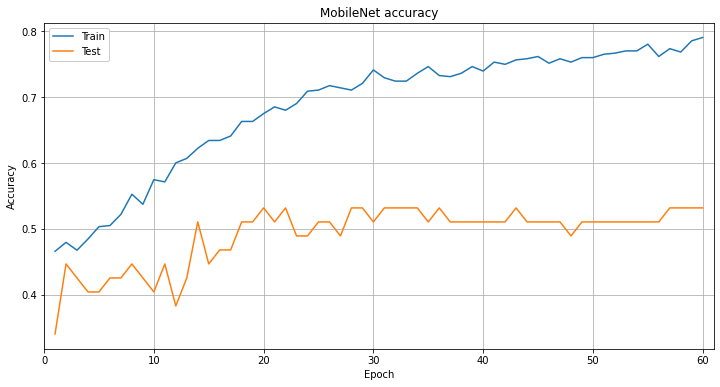

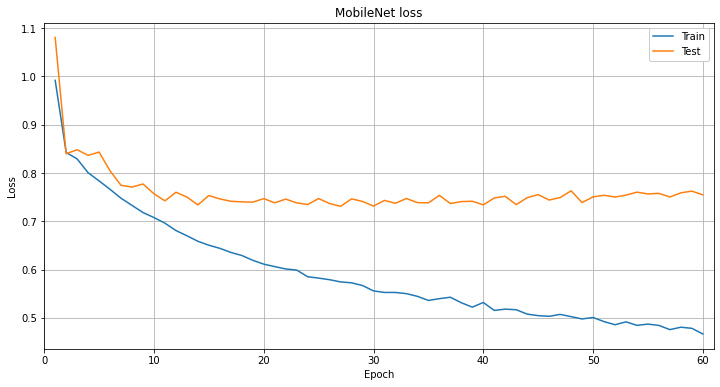

In [ ]:
from keras.callbacks import History
#epochs = 5

# list all data in history
print(history_mobileNet.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_mobileNet.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), history_mobileNet.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('MobileNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left', framealpha=1)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_mobileNet.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), history_mobileNet.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('MobileNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right', framealpha=1)#, fancybox=True)
plt.grid()
plt.show()

#plt.savefig('01_MobileNet_DFV.jpg', dpi=200)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

Confusion matrix, without normalization
[[ 6 10]
 [13 18]]


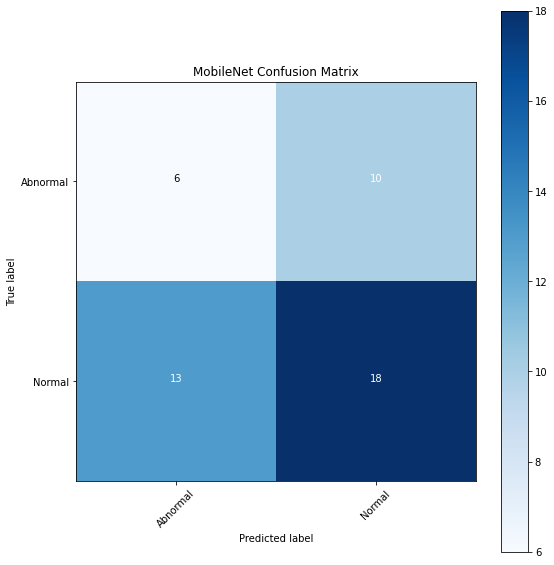

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='MobileNet Confusion Matrix')

In [ ]:
from sklearn.metrics import precision_score , recall_score

#y_val_pred=model.predict_classes(x_val)

print(precision_score(test_labels,predictions.argmax(axis=1),average=None))

[0.31578947 0.64285714]


In [ ]:
print(recall_score(test_labels,predictions.argmax(axis=1),average=None))

[0.375      0.58064516]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.32      0.38      0.34        16
           1       0.64      0.58      0.61        31

    accuracy                           0.51        47
   macro avg       0.48      0.48      0.48        47
weighted avg       0.53      0.51      0.52        47



ROC AUC:  0.4778225806451613


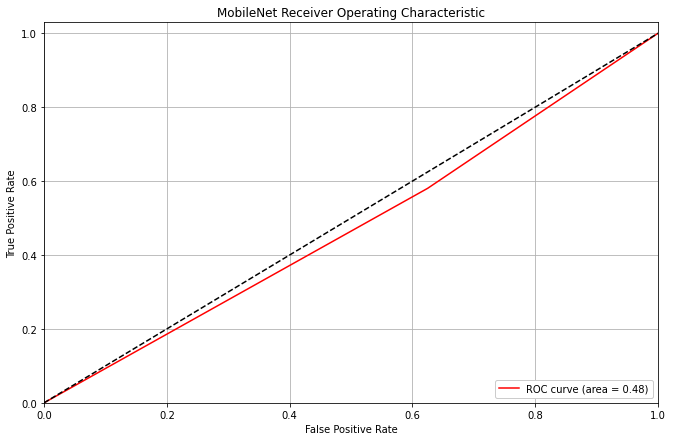

In [ ]:
import sklearn.metrics as metrics
##from sklearn.metrics import roc_curve, auc#, plot_roc_curve
#false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels, predictions.argmax(axis=1))

#cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print("ROC AUC: ", roc_auc)

plt.figure(figsize=(11, 7))
plt.plot(false_positive_rate, true_positive_rate, 'r-', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNet Receiver Operating Characteristic')
plt.legend(loc="lower right", framealpha=1)
plt.grid()
plt.show()

## <b> Densenet 121 </b>

In [ ]:
model_dn121 = tf.keras.applications.densenet.DenseNet121(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    #classes=3
)
#print(model_dn121.summary())

33202176/33188688 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Model

x = model_dn121.layers[-2].output
#reshaped = tf.keras.layers.Reshape((1024,))(x)
output = Dense(units=2, activation='softmax')(x) # Este reshape se agrega porque Keras actualizó la implementación de MobileNet, por esto también cambia -6 a -5
model = Model(inputs=model_dn121.input, outputs=output)

In [ ]:
for layer in model.layers[:-20]:
    layer.trainable = False
#print(model.summary())

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = dataPath01+'/checkpoints/dn121/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#epochs = 60

history_dn121 = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          #batch_size=10,
          epochs=epochs, #60 #35 puede ser suficiente en este caso
          verbose=2,
          callbacks=[model_checkpoint_callback]
          )

Epoch 1/60
12/12 - 20s - loss: 0.8268 - accuracy: 0.5357 - val_loss: 0.6657 - val_accuracy: 0.6170 - 20s/epoch - 2s/step
Epoch 2/60
12/12 - 12s - loss: 0.6127 - accuracy: 0.6667 - val_loss: 0.6759 - val_accuracy: 0.6170 - 12s/epoch - 988ms/step
Epoch 3/60
12/12 - 12s - loss: 0.5557 - accuracy: 0.7075 - val_loss: 0.6920 - val_accuracy: 0.6596 - 12s/epoch - 1s/step
Epoch 4/60
12/12 - 12s - loss: 0.4924 - accuracy: 0.7891 - val_loss: 0.7128 - val_accuracy: 0.6596 - 12s/epoch - 986ms/step
Epoch 5/60
12/12 - 12s - loss: 0.4567 - accuracy: 0.8078 - val_loss: 0.7165 - val_accuracy: 0.6596 - 12s/epoch - 970ms/step
Epoch 6/60
12/12 - 12s - loss: 0.4257 - accuracy: 0.8367 - val_loss: 0.7036 - val_accuracy: 0.6596 - 12s/epoch - 972ms/step
Epoch 7/60
12/12 - 12s - loss: 0.3807 - accuracy: 0.8707 - val_loss: 0.7102 - val_accuracy: 0.6809 - 12s/epoch - 1s/step
Epoch 8/60
12/12 - 12s - loss: 0.3417 - accuracy: 0.9082 - val_loss: 0.7017 - val_accuracy: 0.6383 - 12s/epoch - 991ms/step
Epoch 9/60
12/12 

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

model_name_path = checkpoint_filepath+'dn_seg_U_Net_bin_model.h5'

model.save(model_name_path)  # creates a HDF5 file 'my_model.h5'

del model  # deletes the existing model

# returns a compiled model, identical to the previous one
from keras.models import load_model
model = load_model(model_name_path)

#print(model.summary())

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


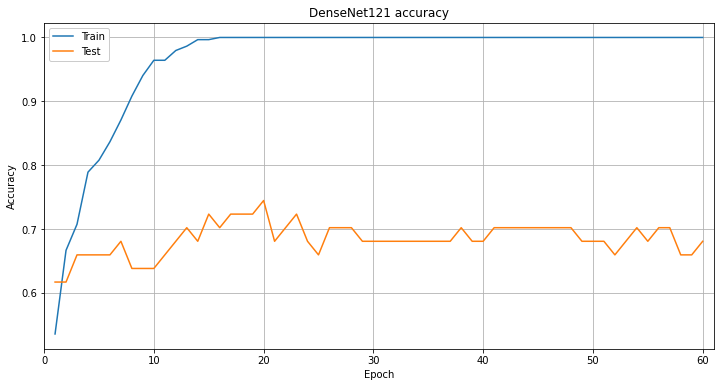

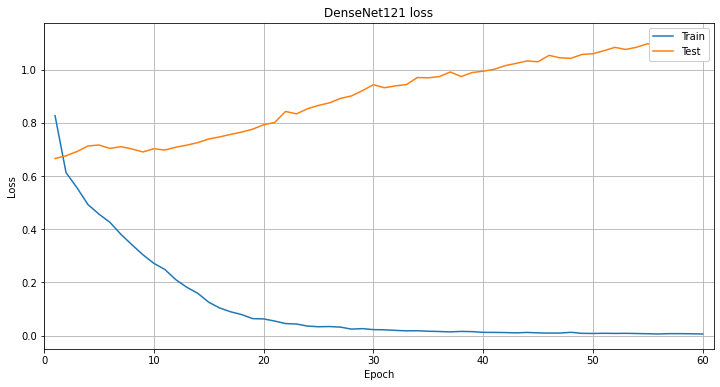

In [ ]:
# list all data in history
print(history_dn121.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('DenseNet121 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left', framealpha=1)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), history_dn121.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('DenseNet121 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right', framealpha=1)#, fancybox=True)
plt.grid()
plt.show()

#plt.savefig('01_DenseNet121_DFV.jpg', dpi=200)

Confusion matrix, without normalization
[[ 5 11]
 [ 6 25]]


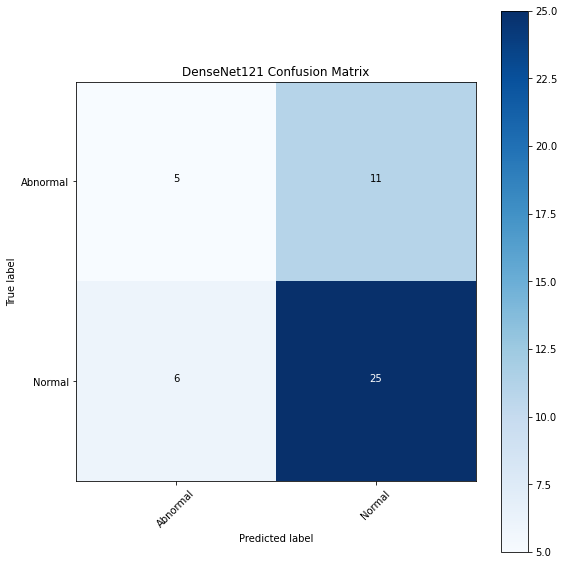

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

cm_plot_labels = ['Abnormal', 'Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='DenseNet121 Confusion Matrix')

In [ ]:
from sklearn.metrics import precision_score , recall_score

#y_val_pred=model.predict_classes(x_val)

print(precision_score(test_labels,predictions.argmax(axis=1),average=None))

[0.45454545 0.69444444]


In [ ]:
print(recall_score(test_labels,predictions.argmax(axis=1),average=None))

[0.3125     0.80645161]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.45      0.31      0.37        16
           1       0.69      0.81      0.75        31

    accuracy                           0.64        47
   macro avg       0.57      0.56      0.56        47
weighted avg       0.61      0.64      0.62        47



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[[0.702167   0.29783306]
 [0.22274682 0.7772532 ]
 [0.19852117 0.80147886]
 [0.39036343 0.6096366 ]
 [0.19137332 0.80862665]
 [0.12187849 0.87812155]
 [0.606082   0.39391795]
 [0.6586115  0.34138846]
 [0.16280442 0.83719563]
 [0.20433183 0.7956682 ]
 [0.52829766 0.4717023 ]
 [0.9312361  0.06876393]
 [0.02234956 0.9776504 ]
 [0.03552172 0.9644783 ]
 [0.02964835 0.9703517 ]
 [0.08624032 0.91375965]
 [0.3541836  0.6458163 ]
 [0.67324305 0.32675695]
 [0.11279585 0.8872041 ]
 [0.30931297 0.690687  ]
 [0.28435782 0.7156422 ]
 [0.23810315 0.76189685]
 [0.08409826 0.9159018 ]
 [0.1848323  0.8151677 ]
 [0.34047174 0.65952826]
 [0.5493848  0.4506152 ]
 [0.17871    0.82128996]
 [0.15112823 0.8488718 ]
 [0.5883323  0.41166767]
 [0.04259187 0.95740813]
 [0.38507277 0.61492723]
 [0.26833758 0.73166245]
 [0.12170229 0.8782977 ]
 [0.5143324  0.48566765]
 [0.72162277 0.27837726]
 [0.13324694 0.8667531 ]
 [0

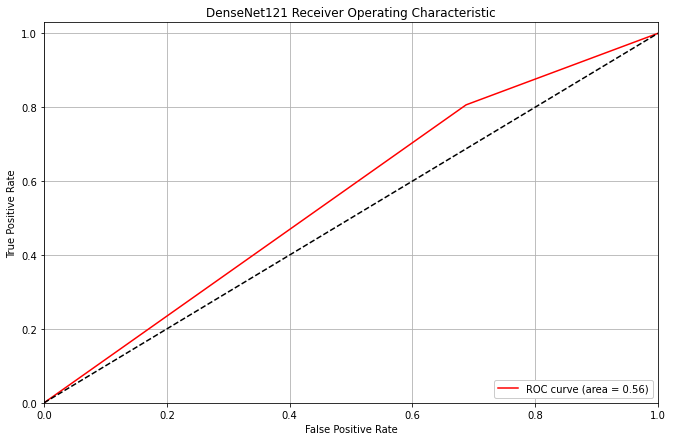

In [ ]:
import sklearn.metrics as metrics
##from sklearn.metrics import roc_curve, auc#, plot_roc_curve
#false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(testY, y_pred)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels, predictions.argmax(axis=1))
print(test_labels)
print(predictions)
print(predictions.argmax(axis=1))
print(false_positive_rate)
print(true_positive_rate)
#cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print("ROC AUC: ", roc_auc)

plt.figure(figsize=(11, 7))
plt.plot(false_positive_rate, true_positive_rate, 'r-', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet121 Receiver Operating Characteristic')
plt.legend(loc="lower right", framealpha=1)
plt.grid()
plt.show()